In [1]:
import time
import os
import numpy as np
import cv2,pathlib
import matplotlib.pyplot as plt

from fringes import fringe_wrapper
from config import config
from phase1 import phase_wrapper, PE, MPSP
from fringes import projection_fringes_save
from recons3d_copy import Recons3D

linetypes = [":>", "--s", "-.<", "-o", "-"]

rmse = lambda diff: np.sqrt(np.nanmean(diff ** 2))
dist = lambda points: np.sqrt(np.sum(points ** 2, axis=-1))

colors = ['c','g','b','r','black','yellow']

def recons3d(disparity):
    h, w = disparity.shape[0:2]
    f = 5.0*w                          # artificial focal length
    Q = np.float32([[5, 0, 0, -0.5*w],
                    [0,-5, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
    points = cv2.reprojectImageTo3D(disparity.astype(np.float32), Q)
    return points

class our_ImageReader():
    def __init__(self, config):
        self._c = config

    def read(self, case, step=[3,3,3], gamma1 = 1.25):
        root = pathlib.Path(self._c.measure_path)
        images = []
        imgs_f1 = []
        imgs_f2 = []
        imgs_f3 = []
        num = step[0] + step[1] + step[2]
        print("num",num)
        for ind in range(num):
            name_h = root / f"{case:0>2d}{ind:0>2d}h.bmp"
            print(name_h)
            img = cv2.imread(name_h.as_posix(), 0)
            height, width = img.shape[:2]
            # print("height, width",height)
            # print("width",width)

            if num == 14:
                start_row, start_col = 490, 0
                end_row, end_col = 540, width
            else:
                start_row, start_col = 0, 0
                end_row, end_col = height, width

            cropped = img[start_row:end_row, start_col:end_col]  # 将图像裁剪成1920 * 50
            # slight gamma correction to avoid outliers
            cropped = np.power(cropped / 255., gamma1) * 255
            cropped = cv2.blur(cropped, (7, 7))
            if ind < step[0]:
                print("f1")
                imgs_f1.append(cropped)
            elif ind < step[0] + step[1]:
                print("f2")
                imgs_f2.append(cropped)
            elif ind < step[0] + step[1] + step[2]:
                print("f3")
                imgs_f3.append(cropped)
        images.append(imgs_f1)
        images.append(imgs_f2)
        images.append(imgs_f3)

        name_h = root / f"{case:0>2d}{num:0>2d}h.bmp"  # this is beijing img
        print(name_h)
        gray = cv2.imread(name_h.as_posix(), 0)

        return images,gray

def phase_to_point(cfg,phase_measures,phase_truth,point_truth):
    disparitys = (phase_measures - phase_truth) * cfg.Tp[0] / (2 * np.pi) + 88
    #print(disparitys)
    point_measures = recons3d(disparitys)
    rmse_point = rmse(dist(point_measures[50:51,140:160,:] - point_truth[50:51,140:160,:]))
    return rmse_point

# save the phase map as a pdf file
def save_phase(phase, fn, vmax=50):
    fig = plt.figure(figsize=(6, 3.5))
    plt.imshow(phase, vmin=0, vmax=vmax)
    plt.colorbar()
    plt.savefig(fn)
    plt.close(fig)

In [2]:



# def test():
#     x = np.linspace(0,1920,1920)
#     phi1 = np.mod(2*np.pi*x/30-2*np.pi/9, 2*np.pi)
#     phi2 = np.mod(2*np.pi*x/30, 2*np.pi)
#     phi3 = np.mod(2*np.pi*x/30+2*np.pi/9, 2*np.pi)
#
#
#     phi = phase_average(phi1, phi2, phi3)
#     plt.figure(figsize=(12,8))
#     plt.plot(phi2+0.1, label="phi2")
#     plt.plot(phi, label="phi")
#     plt.legend()
#     plt.xlim([0,128])
#     plt.grid("on")
#     plt.show()
#
# # test()


In [3]:
def one_case(cfg,case):
    # 20-step truth
    startrow = 50
    endrow = 51
    # cfg = config()
    # 20步相移得到真实值
    cfg.measure_path = "./data/recordings/2/20-step/"
    fringe_images_true, gray_true = our_ImageReader(cfg).read(case=case, step=[20, 20, 20])
    cfg.measure_path = "./data/recordings/2/9-step/"
    fringe_images_nine_step, gray_nine_step = our_ImageReader(cfg).read(case=case, step=[9, 9, 9])
    cfg.measure_path = "./data/recordings/2/12-step/"
    fringe_images_twelve_step, gray_twelve_step = our_ImageReader(cfg).read(case=case, step=[12, 12, 12])
    cfg.measure_path = "./data/recordings/2/3-step/"
    fringe_images_three_step, gray_three_step = our_ImageReader(cfg).read(case=case, step=[3, 3, 3])

    # treat the 20 steps images as the ground truth for phase extraction
    cfg.pe_method = "PE"
    cfg.steps = [20, 20]
    print('20 steps')
    reconstructor = Recons3D(cfg)
    phase_truth = reconstructor.measure(fringe_images_true, gray_true, aa = 0)   # 用20-step求包裹相位
    phase_truth_unwrapped, point_truth = reconstructor.measure(fringe_images_true, gray_true, aa = 1)   # 用20-step相位展开
    # get the phase_truth and point_truth.but the point_truth is not true,because the phase_true is wrapped phase.
    # save the data for truth
    gray_rect = np.array(fringe_images_true).mean(axis=(0, 1))
    gray_rect = reconstructor.remap(gray_rect)
    cv2.imwrite(f"data/results/case_{case:0>2d}_rect.png", gray_rect)
    save_phase(phase_truth, f"data/results/case_{case:0>2d}_phase_truth.pdf")
    # point_truth = recons3d(phase_truth_unwrapped*0+88)

    # 9步相移作比较
    cfg.steps = [9, 9]
    reconstructor = Recons3D(cfg)
    phase_measures_nine_step = reconstructor.measure(fringe_images_nine_step, gray_nine_step, aa = 0)   # 用9-step求包裹相位
    phase_measures_nine_step_unwrapped,point_nine_step = reconstructor.measure(fringe_images_nine_step, gray_nine_step, aa = 1)   # 用9-step相位展开
    nine_step_wrapped_rmse = rmse(phase_measures_nine_step[startrow:endrow,:] - phase_truth[startrow:endrow,:])
    nine_step_unwrapped_rmse = rmse(phase_measures_nine_step_unwrapped[startrow:endrow,:] - phase_truth_unwrapped[startrow:endrow,:])
    nine_step_point_rmse = rmse(point_nine_step[startrow:endrow,:] - point_truth[startrow:endrow,:])
    # nine_step_point_rmse = phase_to_point(cfg, phase_measures_nine_step_unwrapped, phase_truth_unwrapped, point_truth)

    cfg.steps = [3, 3]
    # 新的triple-N方法
    reconstructor = Recons3D(cfg)
    phase_measures6,phase_measures7,phase_measures8,correct_new_triple_n_l, new_triple_n_step_unwrapped_phase, new_triple_n_step_point= reconstructor.measure(fringe_images_nine_step, gray_nine_step, aa = 3)   # 用new_triple_n求包裹相位和解包裹相位
    new_wrapped_rmse = rmse(correct_new_triple_n_l[startrow:endrow,:] - phase_truth[startrow:endrow,:])
    new_unwrapped_rmse = rmse(new_triple_n_step_unwrapped_phase[startrow:endrow,:] - phase_truth_unwrapped[startrow:endrow,:])
    new_triple_n_step_point_rmse = rmse(new_triple_n_step_point[startrow:endrow,:] - point_truth[startrow:endrow,:])
    # new_triple_n_step_point_rmse = phase_to_point(cfg, new_triple_n_step_unwrapped_phase, phase_truth_unwrapped, point_truth)

    # 旧triple-N方法
    reconstructor = Recons3D(cfg)
    phase_measures3,phase_measures4,phase_measures5,correct_old_triple_n_l, old_Triple_N_step_unwrapped_phase, old_Triple_N_step_point = reconstructor.measure(fringe_images_twelve_step, gray_twelve_step, aa = 2)   # 用new_triple_n求包裹相位和解包裹相位
    old_wrapped_rmse = rmse(correct_old_triple_n_l[startrow:endrow,:] - phase_truth[startrow:endrow,:])
    old_unwrapped_rmse = rmse(old_Triple_N_step_unwrapped_phase[startrow:endrow,:] - phase_truth_unwrapped[startrow:endrow, :])
    old_triple_n_step_point_rmse = rmse(old_Triple_N_step_point[startrow:endrow, :] - point_truth[startrow:endrow, :])
    # old_triple_n_step_point_rmse = phase_to_point(cfg, old_Triple_N_step_unwrapped_phase, phase_truth_unwrapped, point_truth)

    # 三步相移做比较
    three_psi = []
    reconstructor = Recons3D(cfg)
    phase_wrapped_three_step = reconstructor.measure(fringe_images_three_step, gray_three_step, aa = 0)   # 用9-step求包裹相位
    three_step_unwrapped_phase,point_three_step = reconstructor.measure(fringe_images_three_step, gray_three_step, aa = 1)   # 用9-step相位展开
    three_step_wrapped_rmse = rmse(phase_wrapped_three_step[startrow:endrow,:]-phase_truth[startrow:endrow, :])
    three_step_unwrapped_rmse = rmse(three_step_unwrapped_phase[startrow:endrow,:]-phase_truth_unwrapped[startrow:endrow, :])
    three_step_point_rmse = rmse(point_three_step[startrow:endrow,:]-point_truth[startrow:endrow, :])
    # three_step_point_rmse = phase_to_point(cfg, three_step_unwrapped_phase, phase_truth_unwrapped, point_truth)

    line = 50
    # 新triple-n-step
    plt.figure(figsize=(12, 8))
    plt.plot(phase_measures6[line,:],color=colors[0], label="2PAI/3N")
    plt.plot(phase_measures7[line,:],color=colors[1],label="new_origin")
    plt.plot(phase_measures8[line,:],color=colors[2],label="4PAI/3N")
    plt.plot(correct_new_triple_n_l[line,:],color=colors[3],label="correct_new_triple_n")
    plt.plot(phase_truth[line,:],color=colors[4],label="truth-phase")
    plt.plot(phase_measures_nine_step[line,:],color=colors[5],label="9-steps")
    # plt.xlim(0,200)
    # plt.plot(phase3_unwrapped[line,:], linetypes[2],color=colors[2],label="phase-truth")
    plt.ylabel("Phase (rad)")
    plt.legend(loc=1)
    plt.grid("on")
    plt.tight_layout()

    # 旧triple-n-step
    plt.figure(figsize=(12, 8))
    plt.plot(phase_measures3[line,:],color=colors[0], label="PAI/2N")
    plt.plot(phase_measures4[line,:],color=colors[1],label="old_origin")
    plt.plot(phase_measures5[line,:],color=colors[2],label="PAI/N")
    plt.plot(correct_old_triple_n_l[line,:],color=colors[3],label="correct_old_triple_n")
    plt.plot(phase_truth[line,:],color=colors[4],label="truth-phase")
    plt.plot(phase_measures_nine_step[line,:],color=colors[5],label="9-steps")
    # plt.xlim(0,200)
    plt.ylabel("Phase (rad)")
    plt.legend(loc=1)
    plt.grid("on")
    plt.tight_layout()

    # 相位展开的效果
    plt.figure(figsize=(12, 8))
    plt.plot(phase_measures_nine_step_unwrapped[line,:],color=colors[0], label="9-step-unwrapped_phase")
    plt.plot(three_step_unwrapped_phase[line,:],color=colors[1], label="three_step_wrapped_phase")
    plt.plot(old_Triple_N_step_unwrapped_phase[line,:],color=colors[2],label="old_Triple_N_step_unwrapped_phase")
    plt.plot(new_triple_n_step_unwrapped_phase[line,:],color=colors[3],label="new_Triple_N_step_unwrapped_phase")
    plt.plot(phase_truth_unwrapped[line,:],color=colors[4],label="truth-phase")
    # plt.xlim(0,200)
    plt.ylabel("Phase (rad)")
    plt.legend(loc=1)
    plt.grid("on")
    plt.tight_layout()
    plt.show()

    print("                       old_Triple-N            new_Triple_N              9-step                    3-step")
    print("rmse(wrapped_phase)    {}     {}      {}      {} ".format(old_wrapped_rmse,new_wrapped_rmse,nine_step_wrapped_rmse,three_step_wrapped_rmse))
    print("rmse(unwrapped_phase)  {}     {}      {}      {} ".format(old_unwrapped_rmse,new_unwrapped_rmse,nine_step_unwrapped_rmse,three_step_unwrapped_rmse))
    print("rmse(point_rmse)       {}    {}     {}     {} ".format(old_triple_n_step_point_rmse,new_triple_n_step_point_rmse,nine_step_point_rmse,three_step_point_rmse))

The results (phase map, point cloud) are saved in dir 'data/results'
num 60
data/recordings/2/20-step/0000h.bmp
f1
data/recordings/2/20-step/0001h.bmp
f1
data/recordings/2/20-step/0002h.bmp
f1
data/recordings/2/20-step/0003h.bmp
f1
data/recordings/2/20-step/0004h.bmp
f1
data/recordings/2/20-step/0005h.bmp
f1
data/recordings/2/20-step/0006h.bmp
f1
data/recordings/2/20-step/0007h.bmp
f1
data/recordings/2/20-step/0008h.bmp
f1
data/recordings/2/20-step/0009h.bmp
f1
data/recordings/2/20-step/0010h.bmp
f1
data/recordings/2/20-step/0011h.bmp
f1
data/recordings/2/20-step/0012h.bmp
f1
data/recordings/2/20-step/0013h.bmp
f1
data/recordings/2/20-step/0014h.bmp
f1
data/recordings/2/20-step/0015h.bmp
f1
data/recordings/2/20-step/0016h.bmp
f1
data/recordings/2/20-step/0017h.bmp
f1
data/recordings/2/20-step/0018h.bmp
f1
data/recordings/2/20-step/0019h.bmp
f1
data/recordings/2/20-step/0020h.bmp
f2
data/recordings/2/20-step/0021h.bmp
f2
data/recordings/2/20-step/0022h.bmp
f2
data/recordings/2/20-step/0

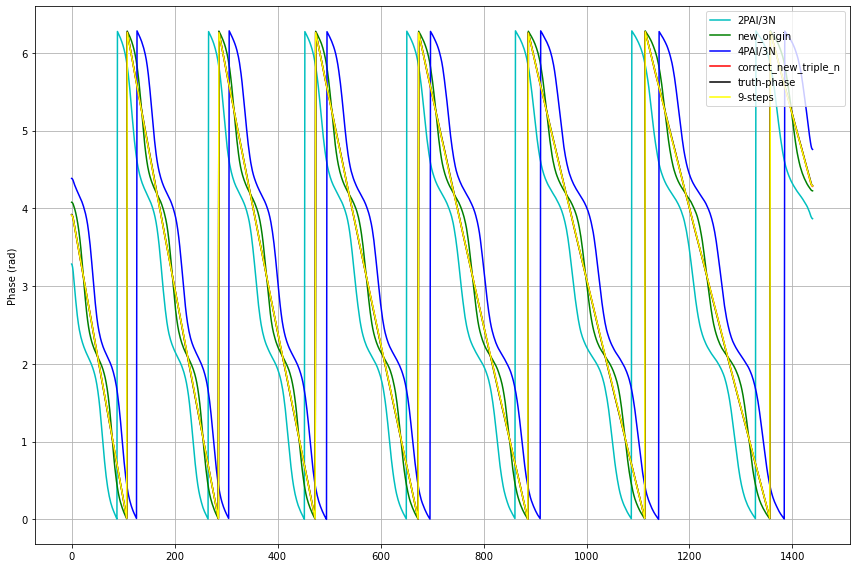

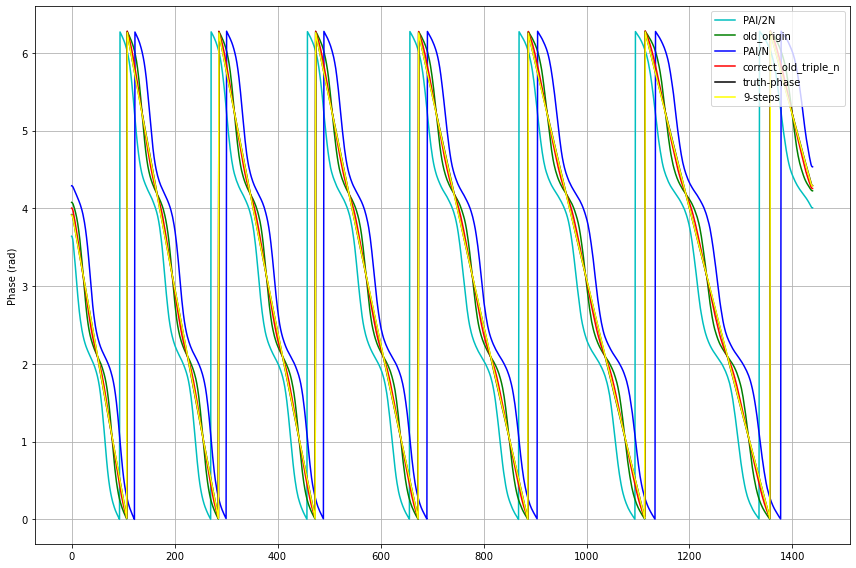

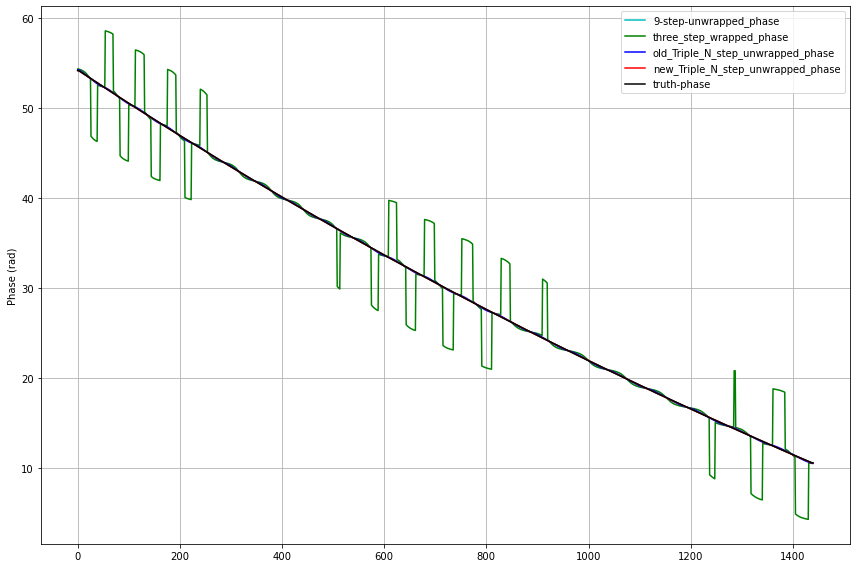

                       old_Triple-N            new_Triple_N              9-step                    3-step
rmse(wrapped_phase)    0.06596510142186442     0.008087695282302403      0.006505878777119333      0.19665637103689043 
rmse(unwrapped_phase)  0.06596510112285614     0.008087693713605404      0.006505907513201237      3.3409178256988525 
rmse(point_rmse)       0.019473830237984657    0.0027707600966095924     0.0023364240769296885     0.830750584602356 


In [4]:
if __name__ == "__main__":
    # config
    cfg = config()
    cfg.debug = False
    cfg.pattern_size = [1920, 1080]
    cfg.camera_size = [1440,1080]
    cfg.Tp = [170, 190]       #在这个实验中，就先设置成这个周期。
    # Note that, we must update Tc and alpha for correct phase extraction
    cfg.Tc = cfg.Tp # Tc is for camera recordings
    # cfg.alpha = [1, cfg.Tp[0]/cfg.Tp[1], cfg.Tp[0]/cfg.Tp[2]]
    gamma1 = 1.25

    print(f"The results (phase map, point cloud) are saved in dir 'data/results'")
    for case in [0]:
        one_case(cfg,case=case)
